In [ ]:
# Standard library
import datetime as dt
import math
import os
import sys
import time
import timeit
import warnings
from io import BytesIO

# Third-party
import fsspec
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymap3d as pm  # for transformation between ENU and llh
import pysolid
import rasterio
import requests
import scipy
import shapely.wkt as wkt
from osgeo import gdal, osr
from pyproj import CRS, Proj
from shapely import geometry

from isce3.core import Ellipsoid as ellips

# Local application/library specific
try:
    from src.ALE_utils import (
        stream_cslc,
        stream_static_layers,
        oversample_slc,
        get_snr_peak,
        findCR,
        enlos2rdr,
    )
except ModuleNotFoundError:
    sys.path.append("../")
    from src.ALE_utils import (
        stream_cslc,
        stream_static_layers,
        oversample_slc,
        get_snr_peak,
        findCR,
        enlos2rdr,
    )

# Ignore warnings
warnings.filterwarnings("ignore")

In [2]:
# Start runtime evaluation
start = timeit.default_timer()

In [3]:
# Parameters for papermill
cslc_url = 's3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_L2_CSLC-S1_T064-135523-IW2_20230625T015058Z_20230907T122709Z_S1A_VV_v0.2/OPERA_L2_CSLC-S1_T064-135523-IW2_20230625T015058Z_20230907T122709Z_S1A_VV_v0.2.h5'
cslc_static_url = 's3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_L2_CSLC-S1-STATIC_T064-135523-IW2_20140403_20230903T090947Z_S1A_v0.2/OPERA_L2_CSLC-S1-STATIC_T064-135523-IW2_20140403_20230903T090947Z_S1A_v0.2.h5'
save_dir = '../test'
burst_id = 't064_135523_iw2'
date = '20220817'
snr_threshold = 15
solidtide = 'False'
cr_network = 'Rosamond'
ovsFactor = 64

In [ ]:
# Access the CSLC data from the database
if not cslc_url.startswith('http') and not cslc_url.startswith('s3'):
    with rasterio.open(cslc_url) as cslc_src:
        subdatasets = cslc_src.subdatasets
        subdataset_1 = subdatasets[0]
        pol = subdataset_1.split('/')[-1]
else:
    pol = cslc_url.split('/')[-1].split('_')[-2]

if cslc_url.startswith('http'):
    response = requests.get(cslc_url)
    s3f = BytesIO(response.content)
else:
    s3f = fsspec.open(cslc_url, mode='rb', anon=True, default_fill_cache=False)

# Stream the data
cslc,azimuth_carrier_phase,flattening_phase,xcoor,ycoor,dx,dy,epsg,sensing_start,sensing_stop,dims,bounding_polygon,orbit_direction,center_lon,center_lat,wavelength = stream_cslc(s3f,pol)
    
# Get bounding box
cslc_poly = wkt.loads(bounding_polygon)

# Deramp the cslc
ramp = np.exp(1j*azimuth_carrier_phase)
cslc = cslc*np.conj(ramp)

# Unflatten the cslc
flat_phase = np.exp(1j*flattening_phase)
cslc = cslc*np.conj(flat_phase) 

In [ ]:
# Get the cslc date and time
date_ = dt.datetime.strptime(sensing_start.astype(str),'%Y-%m-%d %H:%M:%S.%f').strftime('%Y-%m-%d+%H\u0021%M')
#crfile = f"{save_dir}/crdata/crdata_{cslc_url.split('/')[6][:-3]}.csv"
crfile = f'{save_dir}/crdata/crdata_{burst_id.upper()}_{date}.csv'

if not os.path.exists(f'{save_dir}/crdata'):
    os.makedirs(f'{save_dir}/crdata/')
    os.makedirs(f'{save_dir}/pngs/')
    os.makedirs(f'{save_dir}/summary/')

if os.path.exists(crfile) == False and cr_network=='Rosamond':
    # Download corner reflector data from UAVSAR/NISAR based on the date of the CSLC product
    res = requests.get(f'https://uavsar.jpl.nasa.gov/cgi-bin/corner-reflectors.pl?date={str(date_)}&project=rosamond_plate_location')
    # Write to file
    with open(crfile, 'wb') as f:
        f.write(res.content)

elif os.path.exists(crfile) == False and cr_network=='Oklahoma':
    # Download corner reflector data from UAVSAR/NISAR based on the date of the CSLC product
    res = requests.get(f'https://uavsar.jpl.nasa.gov/cgi-bin/corner-reflectors.pl?date={str(date_)}&project=nisar_plate_location')
    # Write to file
    with open(crfile, 'wb') as f:
        f.write(res.content)

elif os.path.exists(crfile) == False and cr_network=='Alaska':
    # Download corner reflector data from NISAR based on the date of the CSLC product
    res = requests.get(f'https://uavsar.jpl.nasa.gov/cgi-bin/corner-reflectors.pl?date={str(date_)}&project=alaska_plate_location')
    # Write to file
    with open(crfile, 'wb') as f:
        f.write(res.content)

elif os.path.exists(crfile) == False and cr_network=='Australia':
    # Download corner reflector data from NISAR based on the date of the CSLC product
    res = requests.get(f'https://uavsar.jpl.nasa.gov/cgi-bin/corner-reflectors.pl?date={str(date_)}&project=australia_plate_location')
    # Write to file
    with open(crfile, 'wb') as f:
        f.write(res.content)

if os.path.exists(crfile) == False:
    raise SystemExit(f'No corner reflector data found for {burst_id}_{date_}. Terminating process.')
else:
    print(f'Corner Reflector Data: crdata_{date}.csv already exists. Skipping download.')

time.sleep(2)
# Read to pandas dataframe and rename columns
df = pd.read_csv(crfile, header=0)
df.columns=["ID", "lat", "lon", "hgt", "azm", "tilt", "slen", " "]
df.drop(columns=[df.columns[-1]], inplace=True)
df.slen = np.round(df.slen,1)
df

,ID,lat,lon,hgt,azm,tilt,slen
0,0,34.796969,-118.096531,660.7859,170.50,12.10,2.4
1,1,34.799849,-118.086989,661.0348,170.50,8.72,2.4
2,2,34.805238,-118.087389,660.7961,170.00,9.30,2.4
3,3,34.805338,-118.081945,660.9921,170.00,8.63,2.4
4,4,34.805415,-118.076378,661.1549,176.00,11.93,2.4
5,5,34.805494,-118.070803,661.2246,171.00,11.07,2.4
6,6,34.805585,-118.065226,661.2517,170.00,10.53,2.4
7,7,34.805670,-118.059667,661.3148,172.00,13.40,2.4
8,8,34.805758,-118.054022,661.5725,170.25,14.53,2.4
9,9,34.805814,-118.048915,661.4452,175.00,10.63,2.4


In [6]:
if df.empty:
    raise SystemExit(f'No corner reflectors found.')

In [7]:
if (solidtide == 'True' ):
    #solid earth tide correction with PySolid
    dateformat = '%Y-%m-%d %H:%M:%S.%f'  #date format of input azimuth time
    dt0 = dt.datetime.strptime(sensing_start,dateformat)
    dt1 = dt.datetime.strptime(sensing_stop,dateformat)
    step_sec = 5                        # sample spacing in time domain in seconds

    for idx, row in df.iterrows():

        llh = [np.deg2rad(row['lon']), np.deg2rad(row['lat']), row['hgt']]  #lon/lat/hgt

        _elp = ellips()
        xyz = _elp.lon_lat_to_xyz(llh) #xyz coordinate of CR

        # compute SET via pysolid
        (dt_out,
         tide_e,
         tide_n,
         tide_u) = pysolid.calc_solid_earth_tides_point(np.rad2deg(llh[1]), np.rad2deg(llh[0]), dt0, dt1,
                                                    step_sec=step_sec,
                                                    display=False,
                                                    verbose=False)

        tide_e = np.mean(tide_e[0:2])
        tide_n = np.mean(tide_n[0:2])
        tide_u = np.mean(tide_u[0:2])

        #updating lat,lon,hgt after SET correction
        llh = pm.enu2geodetic(tide_e, tide_n, tide_u,np.rad2deg(llh[1]),np.rad2deg(llh[0]),llh[2],deg=True)

        df.loc[idx,'lat'] = llh[0]
        df.loc[idx,'lon'] = llh[1]
        df.loc[idx,'hgt'] = llh[2]   

In [8]:
if 'lon' not in df.keys():
    raise SystemExit('No CRs found within burst, exit notebook')

In [9]:
# Calculate the locations of CRs in SAR image
UTMx = []
UTMy = []
xloc = []
yloc = []
xloc_float = []
yloc_float = []
_in = []

for idx, row in df.iterrows():
    
    _Proj = Proj(CRS.from_epsg(epsg))
    _x, _y = _Proj(row['lon'], row['lat'],inverse=False)     #conversion of lat/lon of CRs to UTM coordinates
    
    #location of CRs in SLC image
    _xloc = int((_x-xcoor[0])/dx)    
    _yloc = int((_y-ycoor[0])/dy)
    
    UTMx.append(_x) 
    UTMy.append(_y)
    xloc.append(_xloc)
    yloc.append(_yloc)
    xloc_float.append((_x-xcoor[0])/dx)
    yloc_float.append((_y-ycoor[0])/dy)
    _in.append(cslc_poly.contains(geometry.Point(row['lon'], row['lat'])))
    
df['UTMx'] = UTMx
df['UTMy'] = UTMy
df['xloc'] = xloc
df['yloc'] = yloc
df['xloc_float'] = xloc_float
df['yloc_float'] = yloc_float
df['inPoly'] = _in

#checking whether CRs are in SLC coverage. Including only CRs within SLC image
df = df[df['inPoly']==True]
df.drop('inPoly', axis=1, inplace=True)
df = df.reset_index(drop=True)
df.head()

,ID,lat,lon,hgt,azm,tilt,slen,UTMx,UTMy,xloc,yloc,xloc_float,yloc_float
0,1,34.799849,-118.086989,661.0348,170.5,8.72,2.4,400567.470047,3.851386e+06,1662,3096,1662.994009,3096.927996
1,2,34.805238,-118.087389,660.7961,170.0,9.30,2.4,400537.316226,3.851984e+06,1656,3037,1656.963245,3037.124415
2,3,34.805338,-118.081945,660.9921,170.0,8.63,2.4,401035.452879,3.851990e+06,1756,3036,1756.590576,3036.544860
3,4,34.805415,-118.076378,661.1549,176.0,11.93,2.4,401544.734206,3.851993e+06,1858,3036,1858.446841,3036.236754
4,5,34.805494,-118.070803,661.2246,171.0,11.07,2.4,402054.776576,3.851996e+06,1960,3035,1960.455315,3035.914770


In [10]:
# Select CRs according to orbit direction
if cr_network=='Rosamond' or cr_network=='Oklahoma':
    if orbit_direction == 'Ascending':
        df_filter = df[(df['azm']>140) & (df['azm']<220)].reset_index(drop=True)
        #only west-looking CRs (for right-looking ascending)
    else:     #Descending
        df_filter = df[~((df['azm']>140) & (df['azm']<220))].reset_index(drop=True)
        #only east-looking CRs (for right-looking descending)
if cr_network=='Alaska':
    if orbit_direction == 'Ascending':
        # only west-looking CRs (for right-looking ascending)
        df_filter = df.loc[(df['azm']>160) & (df['azm']<200)]
        # reject N32A if data from past 20220601 as it got overturned
        if dt.datetime.strptime('20220601', '%Y%m%d') <= dt.datetime.strptime(str(date), '%Y%m%d'):
            df_filter = df_filter[df_filter['ID']!='N32A'].reset_index(drop=True)
    else:     #Descending
        # only east-looking CRs (for right-looking descending)
        df_filter = df[df['azm']<20].reset_index(drop=True)

df_filter = df_filter.loc[df_filter['slen']>0.8].reset_index(drop=True)   #excluding SWOT CRs (0.7 m as a side length)
df = None
df_filter

,ID,lat,lon,hgt,azm,tilt,slen,UTMx,UTMy,xloc,yloc,xloc_float,yloc_float
0,1,34.799849,-118.086989,661.0348,170.50,8.72,2.4,400567.470047,3.851386e+06,1662,3096,1662.994009,3096.927996
1,2,34.805238,-118.087389,660.7961,170.00,9.30,2.4,400537.316226,3.851984e+06,1656,3037,1656.963245,3037.124415
2,3,34.805338,-118.081945,660.9921,170.00,8.63,2.4,401035.452879,3.851990e+06,1756,3036,1756.590576,3036.544860
3,4,34.805415,-118.076378,661.1549,176.00,11.93,2.4,401544.734206,3.851993e+06,1858,3036,1858.446841,3036.236754
4,5,34.805494,-118.070803,661.2246,171.00,11.07,2.4,402054.776576,3.851996e+06,1960,3035,1960.455315,3035.914770
5,6,34.805585,-118.065226,661.2517,170.00,10.53,2.4,402565.075159,3.852001e+06,2062,3035,2062.515032,3035.447927
6,7,34.805670,-118.059667,661.3148,172.00,13.40,2.4,403073.673056,3.852005e+06,2164,3035,2164.234611,3035.042780
7,8,34.805758,-118.054022,661.5725,170.25,14.53,2.4,403590.096640,3.852009e+06,2267,3034,2267.519328,3034.610319
8,9,34.805814,-118.048915,661.4452,175.00,10.63,2.4,404057.285597,3.852010e+06,2360,3034,2360.957119,3034.475546
9,10,34.805925,-118.043367,661.5140,177.00,9.80,2.4,404564.920162,3.852017e+06,2462,3033,2462.484032,3033.769887


In [11]:
if df_filter.empty:
    raise SystemExit(f'No corner reflectors for this {orbit_direction} track.')

20220817


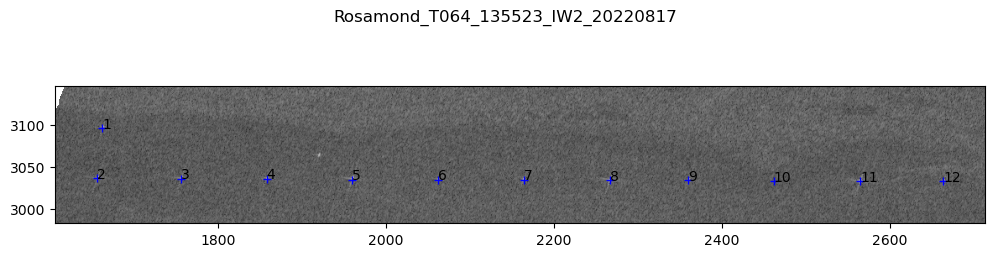

In [12]:
# Displaying SLC image
buffer = 50
minX = np.nanmin(df_filter['xloc']) - buffer
maxX = np.nanmax(df_filter['xloc']) + buffer
minY = np.nanmin(df_filter['yloc']) - buffer
maxY = np.nanmax(df_filter['yloc']) + buffer

scale_ = 1.0
exp_ = 0.15

fig, ax = plt.subplots(figsize=(12, 3))
cax=ax.imshow(scale_*(np.abs(cslc))**exp_, cmap='gray',interpolation=None, origin='upper')
print(f'{date}')
ax.set_xlim(minX,maxX)
ax.set_ylim(minY,maxY)

for sl in pd.unique(df_filter.slen):
    xx = df_filter.loc[df_filter['slen']==sl]['xloc']
    yy = df_filter.loc[df_filter['slen']==sl]['yloc']
    ID = df_filter.loc[df_filter['slen']==sl]['ID']
    
    if sl == 2.4:
        color='blue'
    elif sl == 4.8:
        color='red'
    elif sl == 2.8:
        color='yellow'
    else:
        color='green'
    
    ax.scatter(xx,yy,color=color,marker="+",lw=1)
    for _ID,_xx,_yy in zip(ID,xx,yy):
        ax.annotate(_ID, (_xx, _yy), fontsize=10)

ax.set_aspect(1)
fig.suptitle(f'{cr_network}_{burst_id.upper()}_{date}')
fig.savefig(f'{save_dir}/pngs/OPERA_L2_CSLC-S1_{cr_network}_{burst_id.upper()}_{date}.png',dpi=300,bbox_inches='tight')

,ID,lat,lon,hgt,azm,tilt,slen,UTMx,UTMy,xloc,yloc,xloc_float,yloc_float,xloc_CR,yloc_CR,snr
0,1,34.799849,-118.086989,661.0348,170.50,8.72,2.4,400567.470047,3.851386e+06,1662,3096,1662.994009,3096.927996,1663.154369,3096.876295,15.446024
1,2,34.805238,-118.087389,660.7961,170.00,9.30,2.4,400537.316226,3.851984e+06,1656,3037,1656.963245,3037.124415,1657.048220,3037.138444,15.842846
2,3,34.805338,-118.081945,660.9921,170.00,8.63,2.4,401035.452879,3.851990e+06,1756,3036,1756.590576,3036.544860,1756.696552,3036.507315,15.311377
3,4,34.805415,-118.076378,661.1549,176.00,11.93,2.4,401544.734206,3.851993e+06,1858,3036,1858.446841,3036.236754,1858.712916,3036.273812,14.271422
4,5,34.805494,-118.070803,661.2246,171.00,11.07,2.4,402054.776576,3.851996e+06,1960,3035,1960.455315,3035.914770,1960.538777,3035.877039,14.248704
5,6,34.805585,-118.065226,661.2517,170.00,10.53,2.4,402565.075159,3.852001e+06,2062,3035,2062.515032,3035.447927,2062.683335,3035.386610,14.795490
6,7,34.805670,-118.059667,661.3148,172.00,13.40,2.4,403073.673056,3.852005e+06,2164,3035,2164.234611,3035.042780,2164.269936,3035.033814,15.271796
7,8,34.805758,-118.054022,661.5725,170.25,14.53,2.4,403590.096640,3.852009e+06,2267,3034,2267.519328,3034.610319,2267.621704,3034.613366,15.256168
8,9,34.805814,-118.048915,661.4452,175.00,10.63,2.4,404057.285597,3.852010e+06,2360,3034,2360.957119,3034.475546,2360.967487,3034.508073,15.288821
9,10,34.805925,-118.043367,661.5140,177.00,9.80,2.4,404564.920162,3.852017e+06,2462,3033,2462.484032,3033.769887,2462.792001,3033.863742,9.184240


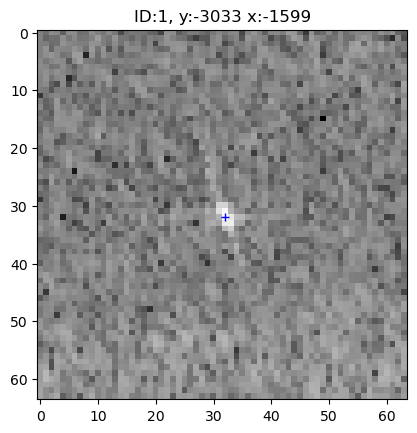

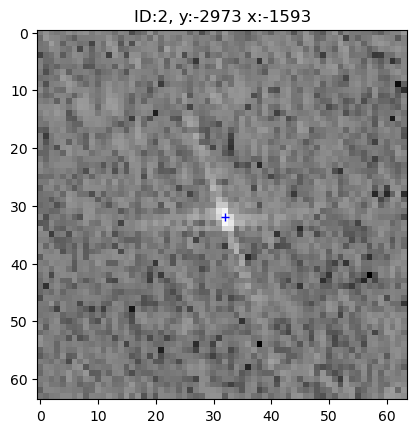

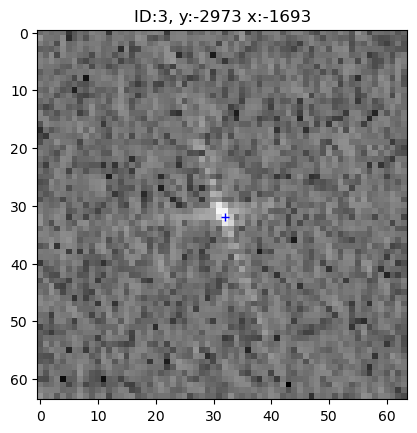

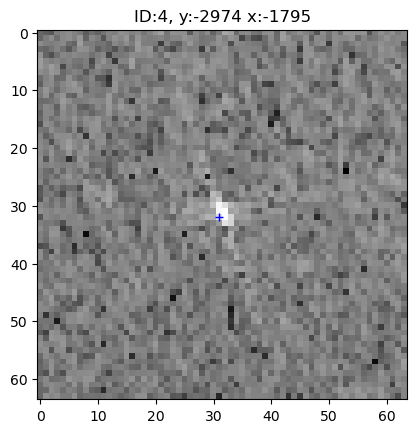

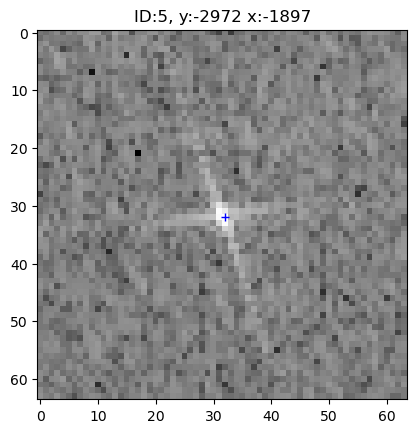

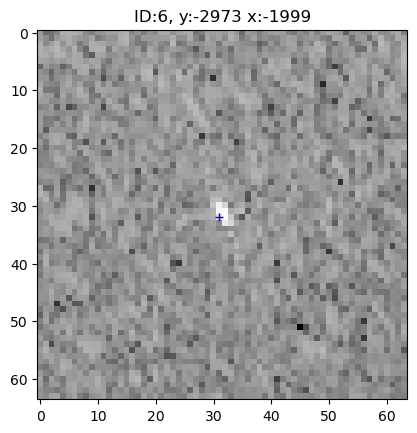

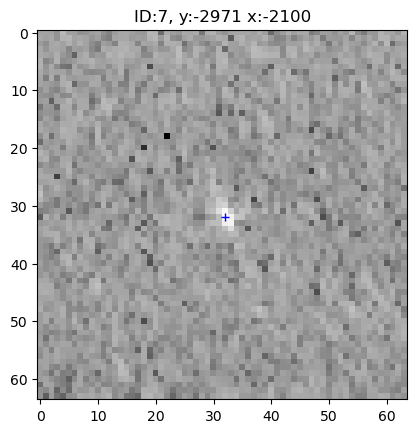

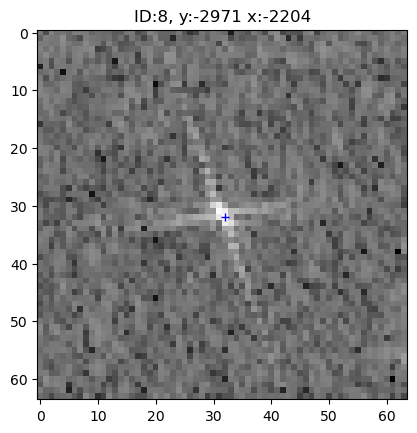

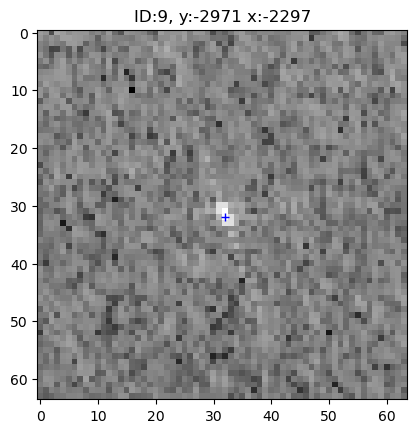

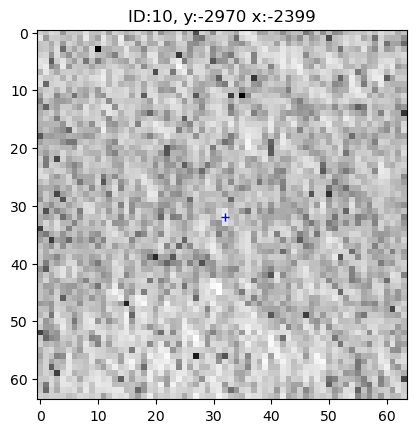

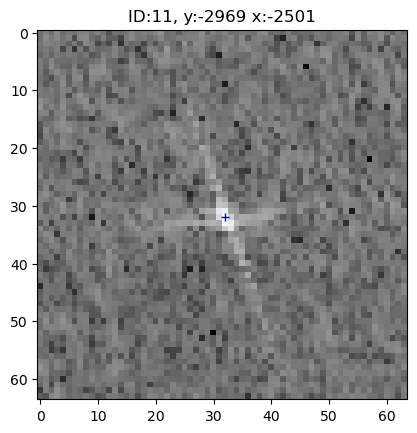

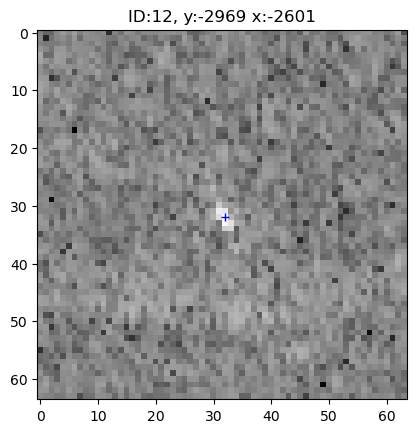

In [13]:
xpeak = []
ypeak = []
snr = []

for ID, xoff, yoff in zip(df_filter['ID'],df_filter['xloc'],df_filter['yloc']):
    # crop a patch of 10*10 with center at the calculated CR position
    pxbuff = 5
    pybuff = 5
    cropcslc = cslc[(yoff-pybuff):(yoff+pybuff),(xoff-pxbuff):(xoff+pxbuff)]
    _snr = get_snr_peak(cropcslc)

    # find the peak amplitude in the 10*10 patch
    yind,xind = np.unravel_index(np.argmax(np.abs(cropcslc), axis=None), cropcslc.shape)
    
    # give a warning if the peak and the calculated postion are too far
    dyind = yind-pybuff; dxind = xind-pxbuff
    dist = math.sqrt(dyind**2+dxind**2)
    if dist > 5.0:
        warnings.warn(f'the most bright pixel and the xloc is too far for CR {ID}')
    
    # crop a patch of 32*32 but with its center at the peak
    xbuff = 32
    ybuff = 32
    ycrop = np.arange(yoff+dyind-ybuff,yoff+dyind+ybuff)
    xcrop = np.arange(xoff+dxind-xbuff,xoff+dxind+xbuff)
    cropcslc = cslc[ycrop,:][:,xcrop]

    # Oversample slc
    cropcslc_ovs,ycrop_ovs,xcrop_ovs = oversample_slc(cropcslc,sampling=ovsFactor,y=ycrop,x=xcrop)

    # find the peak amplitude again in a 2 x 2 patch, it correspond to 
    # (2*ovsFactor) x (2*ovsFactor) in oversampled slc
    yoff2 = int(cropcslc_ovs.shape[0]/2)
    xoff2 = int(cropcslc_ovs.shape[1]/2)
    cropcslc2 = cropcslc_ovs[yoff2-ovsFactor:yoff2+ovsFactor+1,
                           xoff2-ovsFactor:xoff2+ovsFactor+1]
    yind2,xind2 = np.unravel_index(np.argmax(abs(cropcslc2), axis=None), cropcslc2.shape)
    dyind2 = yind2-ovsFactor; dxind2 = xind2-ovsFactor
    
    # crop a patch of 3x3 oversampled patch with center at the peak
    cropcslc2 = cropcslc_ovs[yoff2+dyind2-1:yoff2+dyind2+2,xoff2+dxind2-1:xoff2+dxind2+2]
    ycrop2 = ycrop_ovs[yoff2+dyind2-1:yoff2+dyind2+2]
    xcrop2 = xcrop_ovs[xoff2+dxind2-1:xoff2+dxind2+2]
    xxcrop2,yycrop2 = np.meshgrid(xcrop2,ycrop2)
    xxcrop2_f = xxcrop2.flatten()
    yycrop2_f = yycrop2.flatten()
    cropcslc2_f = cropcslc2.flatten()

    # Check if pixel values in a patch are non-NaN
    valid = ~(np.isnan(cropcslc2_f))
    count_valid = np.count_nonzero(valid)

    if count_valid == 0:
        _ypeak, _xpeak = [np.nan, np.nan]

    else:
        _ypeak,_xpeak = findCR(np.abs(cropcslc2_f[valid]),yycrop2_f[valid],xxcrop2_f[valid],
                            x_bound=[xcrop2[0],xcrop2[-1]],y_bound=[ycrop2[0],ycrop2[-1]],method="para")

    xpeak.append(_xpeak)
    ypeak.append(_ypeak)
    snr.append(_snr)

    # Get observed RCS and then plot
    I_dB = 10*np.log10(cropcslc.real**2 + cropcslc.imag**2)
    if ~np.isnan(_ypeak) | ~np.isnan(_xpeak):
        ypk = int(np.round(_ypeak)) -( yoff+dyind-ybuff); xpk = int(np.round(_xpeak)) - (xoff+dxind-xbuff)
        plt.figure(); plt.imshow(I_dB,cmap='gray',interpolation=None, origin='upper'); plt.plot(ypk,xpk, marker='+', color='b'); plt.title(f'ID:{ID}, y:{ypk-(yoff+dyind-ybuff)} x:{xpk-(xoff+dxind-xbuff)}')

df_filter['xloc_CR'] = xpeak
df_filter['yloc_CR'] = ypeak
df_filter['snr'] = snr
df_filter

In [14]:
df_filter = df_filter.dropna()
df_filter = df_filter[df_filter.snr > snr_threshold]
df_filter

,ID,lat,lon,hgt,azm,tilt,slen,UTMx,UTMy,xloc,yloc,xloc_float,yloc_float,xloc_CR,yloc_CR,snr
0,1,34.799849,-118.086989,661.0348,170.50,8.72,2.4,400567.470047,3.851386e+06,1662,3096,1662.994009,3096.927996,1663.154369,3096.876295,15.446024
1,2,34.805238,-118.087389,660.7961,170.00,9.30,2.4,400537.316226,3.851984e+06,1656,3037,1656.963245,3037.124415,1657.048220,3037.138444,15.842846
2,3,34.805338,-118.081945,660.9921,170.00,8.63,2.4,401035.452879,3.851990e+06,1756,3036,1756.590576,3036.544860,1756.696552,3036.507315,15.311377
6,7,34.805670,-118.059667,661.3148,172.00,13.40,2.4,403073.673056,3.852005e+06,2164,3035,2164.234611,3035.042780,2164.269936,3035.033814,15.271796
7,8,34.805758,-118.054022,661.5725,170.25,14.53,2.4,403590.096640,3.852009e+06,2267,3034,2267.519328,3034.610319,2267.621704,3034.613366,15.256168
8,9,34.805814,-118.048915,661.4452,175.00,10.63,2.4,404057.285597,3.852010e+06,2360,3034,2360.957119,3034.475546,2360.967487,3034.508073,15.288821
10,11,34.806025,-118.037736,661.7012,170.00,14.60,2.4,405080.081202,3.852023e+06,2565,3033,2565.516240,3033.201634,2565.111947,3033.336155,15.829666
11,12,34.806074,-118.032302,661.9130,169.50,8.10,2.4,405577.229290,3.852023e+06,2664,3033,2664.945858,3033.169627,2664.940194,3033.170355,15.734788


In [15]:
if df_filter.empty:
    raise SystemExit(f'No corner reflector left. SNR is too low.')

In [16]:
# Stream the s3url from the validation table
# Searches for available *static_layer.h5 if s3url does not
los_east, los_north = stream_static_layers(cslc_static_url)

In [17]:
# absolute geolocation error in Easting and Northing directions 
ALE_EW = (df_filter['xloc_CR'] -  df_filter['xloc_float'])*dx
ALE_NS = (df_filter['yloc_CR'] - df_filter['yloc_float'])*np.abs(dy)

# Convert to ground range and azimuth offsets
#ALE_Rg, ALE_Az = en2rdr(ALE_EW, ALE_NS, azimuth_angle[df_filter['yloc'], df_filter['xloc']], incidence_angle[df_filter['yloc'], df_filter['xloc']])
ALE_Rg, ALE_Az = enlos2rdr(ALE_EW, ALE_NS, los_east[df_filter['yloc'], df_filter['xloc']], los_north[df_filter['yloc'], df_filter['xloc']])

# Add to the dataframe
df_filter.loc[:,"los_east"] = los_east[df_filter['yloc'], df_filter['xloc']]
df_filter.loc[:,"los_north"] = los_north[df_filter['yloc'], df_filter['xloc']]
df_filter.loc[:,"ALE_EW"] = ALE_EW
df_filter.loc[:,"ALE_NS"] = ALE_NS
df_filter.loc[:,"ALE_Rg"] = ALE_Rg
df_filter.loc[:,"ALE_Az"] = ALE_Az
df_filter

,ID,lat,lon,hgt,azm,tilt,slen,UTMx,UTMy,xloc,...,yloc_float,xloc_CR,yloc_CR,snr,los_east,los_north,ALE_EW,ALE_NS,ALE_Rg,ALE_Az
0,1,34.799849,-118.086989,661.0348,170.50,8.72,2.4,400567.470047,3.851386e+06,1662,...,3096.927996,1663.154369,3096.876295,15.446024,-0.584671,-0.107736,0.801797,-0.517010,-0.694831,-0.653749
1,2,34.805238,-118.087389,660.7961,170.00,9.30,2.4,400537.316226,3.851984e+06,1656,...,3037.124415,1657.048220,3037.138444,15.842846,-0.584732,-0.107742,0.424875,0.140287,-0.443262,0.060974
2,3,34.805338,-118.081945,660.9921,170.00,8.63,2.4,401035.452879,3.851990e+06,1756,...,3036.544860,1756.696552,3036.507315,15.311377,-0.585171,-0.107789,0.529883,-0.375448,-0.453102,-0.465227
6,7,34.805670,-118.059667,661.3148,172.00,13.40,2.4,403073.673056,3.852005e+06,2164,...,3035.042780,2164.269936,3035.033814,15.271796,-0.586950,-0.107981,0.176624,-0.089661,-0.157487,-0.120138
7,8,34.805758,-118.054022,661.5725,170.25,14.53,2.4,403590.096640,3.852009e+06,2267,...,3034.610319,2267.621704,3034.613366,15.256168,-0.587399,-0.108030,0.511878,0.030475,-0.508947,-0.062615
8,9,34.805814,-118.048915,661.4452,175.00,10.63,2.4,404057.285597,3.852010e+06,2360,...,3034.475546,2360.967487,3034.508073,15.288821,-0.587803,-0.108073,0.051840,0.325264,-0.109802,0.310527
10,11,34.806025,-118.037736,661.7012,170.00,14.60,2.4,405080.081202,3.852023e+06,2565,...,3033.201634,2565.111947,3033.336155,15.829666,-0.588692,-0.108168,-2.021464,1.345213,1.745077,1.688378
11,12,34.806074,-118.032302,661.9130,169.50,8.10,2.4,405577.229290,3.852023e+06,2664,...,3033.169627,2664.940194,3033.170355,15.734788,-0.589122,-0.108214,-0.028319,0.007278,0.026538,0.012275


Text(0.5, 0.98, 'Absolute location error for 20220817 (Eastings vs Northings)')

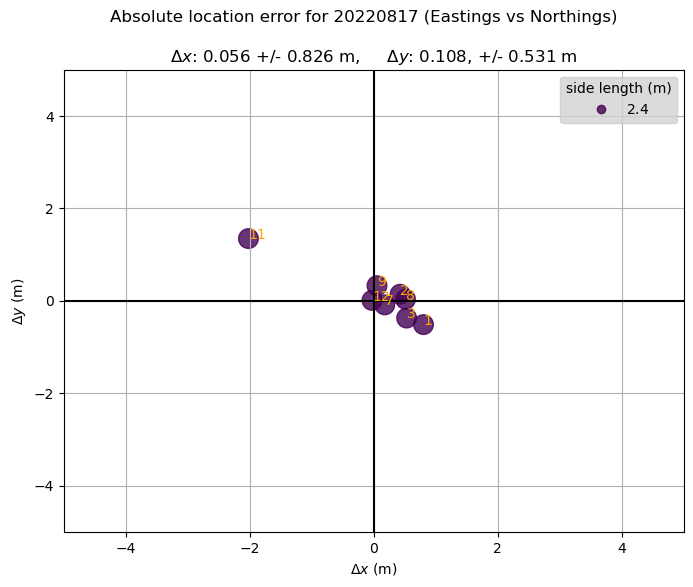

In [18]:
#plotting ALE
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(df_filter.ALE_EW, df_filter.ALE_NS, s=200, c=df_filter['slen'], alpha=0.8, marker='o')
ax.legend(*sc.legend_elements(),facecolor='lightgray')
ax.get_legend().set_title('side length (m)')
for ii, txt in enumerate(df_filter.ID):
    ax.annotate(txt, (df_filter[df_filter['ID']==txt].ALE_EW, df_filter[df_filter['ID']==txt].ALE_NS), color='orange')   #putting IDs in each CR
ax.grid(True)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set_title(f'$\Delta x$: {np.round(np.nanmean(ALE_EW), 3)} +/- {np.round(np.nanstd(ALE_EW),3)} m, \
    $\Delta y$: {np.round(np.nanmean(ALE_NS),3)}, +/- {np.round(np.nanstd(ALE_NS),3)} m')
ax.set_xlabel('$\Delta x$ (m)')
ax.set_ylabel('$\Delta y$ (m)')
fig.suptitle(f'Absolute location error for {date} (Eastings vs Northings)')

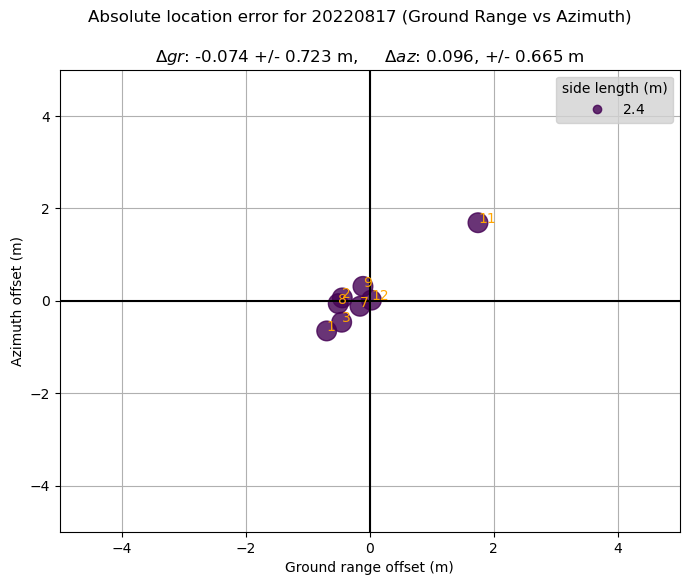

In [19]:
#plotting ALE
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(df_filter.ALE_Rg, df_filter.ALE_Az, s=200, c=df_filter['slen'], alpha=0.8, marker='o')
ax.legend(*sc.legend_elements(),facecolor='lightgray')
ax.get_legend().set_title('side length (m)')
for ii, txt in enumerate(df_filter.ID):
    ax.annotate(txt, (df_filter[df_filter['ID']==txt].ALE_Rg, df_filter[df_filter['ID']==txt].ALE_Az), color='orange')   #putting IDs in each CR
ax.grid(True)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set_title(f'$\Delta gr$: {np.round(np.nanmean(ALE_Rg), 3)} +/- {np.round(np.nanstd(ALE_Rg),3)} m, \
    $\Delta az$: {np.round(np.nanmean(ALE_Az),3)}, +/- {np.round(np.nanstd(ALE_Az),3)} m')
ax.set_xlabel('Ground range offset (m)')
ax.set_ylabel('Azimuth offset (m)')
fig.suptitle(f'Absolute location error for {date} (Ground Range vs Azimuth)')
fig.savefig(f'{save_dir}/pngs/ALE_{cr_network}_{burst_id.upper()}_{date}.png',dpi=300,bbox_inches='tight')

In [20]:
# Save the summary
ALE_EW_Mean = np.round(np.nanmean(ALE_EW),3)
ALE_NS_Mean = np.round(np.nanmean(ALE_NS),3)
ALE_EW_Stdev = np.round(np.nanstd(ALE_EW),3)
ALE_NS_Stdev = np.round(np.nanstd(ALE_NS),3)
ALE_Rg_Mean = np.round(np.nanmean(ALE_Rg),3)
ALE_Az_Mean = np.round(np.nanmean(ALE_Az),3)
ALE_Rg_Stdev = np.round(np.nanstd(ALE_Rg),3)
ALE_Az_Stdev = np.round(np.nanstd(ALE_Az),3)

summary = []
summary.append([date, ALE_EW_Mean, ALE_EW_Stdev, ALE_NS_Mean, ALE_NS_Stdev, ALE_Rg_Mean, ALE_Rg_Stdev, ALE_Az_Mean, ALE_Az_Stdev])
summary_df = pd.DataFrame(summary)
summary_df.to_csv(f'{save_dir}/summary/ALE_{cr_network}_{burst_id.upper()}.csv', mode='a', header=False)

# Save the entire dataframe to csv
df_filter.loc[:,"Date"] = [date]* len(df_filter)
df_filter.to_csv(f'{save_dir}/summary/ALE_{cr_network}_{burst_id.upper()}_ID.csv', mode='a', header=False)

In [21]:
# End runtime evaluation
stop = timeit.default_timer()
print(f'Time: ', (stop - start)/60, 'min.')

Time:  1.7761336302333348 min.
